# Introduction


- ERDDAP rich responses and RESTful API is makes it **THE** most convenient way to serve data.

- A typical ERDDAP URL looks like this:


<sub><sup>[https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z
&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0](https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0)</sup></sub>

Let's break it down to smaller parts

- **server**: https://data.ioos.us/gliders/erddap/
- **protocol**: tabledap
- **dataet_id**: blue-20160818T1448.csv
- **variables**: depth,latitude,longitude,temperature,time
- **constraints**:
    - time>=2016-07-10T00:00:00Z
    - time<=2017-02-10T00:00:00Z
    - latitude>=38.0
    - latitude<=41.0
    - longitude>=-72.0
    - longitude<=-69.0

# *erddapy*'s goal is to make it easier to create these URLs


![tar.png](https://imgs.xkcd.com/comics/tar.png)

In [1]:
server = 'https://data.ioos.us/gliders/erddap'

dataset_id = 'whoi_406-20160902T1700'

constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': '2017-02-10T00:00:00Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0,
}

variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

In [2]:
from erddapy import ERDDAP

e = ERDDAP(
    server=server,
    dataset_id=dataset_id,
    constraints=constraints,
    variables=variables,
    protocol='tabledap',
    response='mat',
)

print(e.get_download_url())

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


# Talk is cheap, so me the data!

There are a few methods to obtain the data with *to_pandas()* and *to_xarray()*:

In [3]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2016-09-03 20:15:46,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46,8.43,40.990881,-71.12439,32.224503,20.5691


In [4]:
ds = e.to_xarray(decode_times=False)

ds['temperature']

<xarray.DataArray 'temperature' (row: 48490)>
array([20.662001, 20.651199, 20.6047  , ..., 18.9417  , 19.0459  , 19.273701])
Coordinates:
    depth      (row) float64 ...
    latitude   (row) float64 ...
    longitude  (row) float64 ...
    time       (row) float64 ...
Dimensions without coordinates: row
Attributes:
    _ChunkSizes:          73
    actual_range:         [ 9.9473 22.6177]
    ancillary_variables:  qartod_temperature_climatological_flag qartod_tempe...
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ioos_category:        Temperature
    long_name:            Sea Water Temperature
    observation_type:     measured
    platform:             platform
    standard_name:        sea_water_temperature
    units:                Celsius
    valid_max:            40.0
    valid_min:            -5.0

# Let's plot the data

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

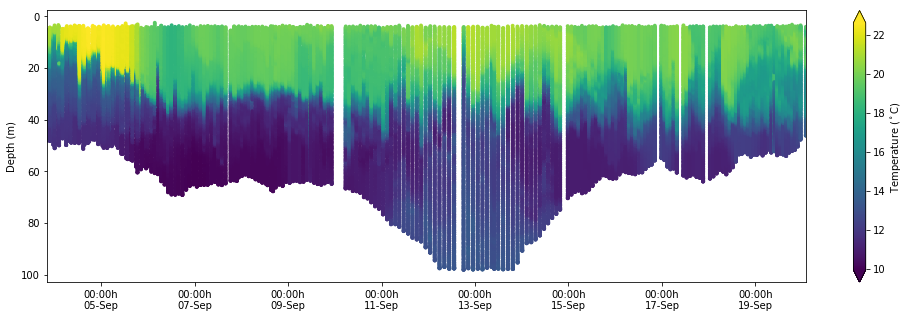

In [6]:
fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=15, c=df['temperature'], marker='o', edgecolor='none')
cs = ax.scatter(df.index, df['depth'], **kw)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

# We can also explore interactively an ERDDAP server

In [7]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap'
)

In [8]:
import pandas as pd


df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))

In [9]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 364 tabledap, 0 griddap, and 0 wms endpoints.'

# Let's refine our search

Let's narrow the search area, time span, and look for *sea_water_temperature* only.

In [10]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -72.0,
    'max_lon': -69.0,
    'min_lat': 38.0,
    'max_lat': 41.0,
    'min_time': '2016-07-10T00:00:00Z',
    'max_time': '2017-02-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [11]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

msg = 'Found {} Glider Datasets:\n\n{}'.format
print(msg(len(gliders), '\n'.join(gliders)))

Found 11 Glider Datasets:

alldrudnickGliders
blue-20160818T1448
cp_335-20170116T1459
cp_336-20161011T0027
cp_336-20170116T1254
cp_374-20160529T0035
cp_380-20161011T2046
cp_389-20161011T2040
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


# Once we know the *Dataset IDs* we can explore its metadata with *get_info_url*

In [12]:
print(gliders[0])

info_url = e.get_info_url(dataset_id=gliders[0], response='csv')
info = pd.read_csv(info_url)

info.head()

alldrudnickGliders


,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgment,String,This deployment supported by NOAA.
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,contributor_name,String,Bob Simons (bob.simons@noaa.gov)


In [13]:
cdm_profile_variables = info.loc[
    info['Attribute Name'] == 'cdm_profile_variables', 'Value'
]

print(''.join(cdm_profile_variables))

profile_id, time, latitude, longitude, time_uv, lat_uv, lon_uv, u, v


# Selecting variables by attributes

In [14]:
e.get_var_by_attr(
    dataset_id='blue-20160818T1448',
    standard_name='sea_water_temperature'
)

['temperature']

# Easy to use CF conventions standards

In [15]:
axis = e.get_var_by_attr(
    dataset_id='blue-20160818T1448',
    axis=lambda v: v in ['X', 'Y', 'Z', 'T']
)
axis

['time', 'latitude', 'longitude', 'depth']

In [16]:
def get_cf_vars(e, dataset_id, standard_names=['sea_water_temperature', 'sea_water_practical_salinity']):
    """Return the axis of a dataset_id the variable with the `standard_name`."""
    variables = e.get_var_by_attr(dataset_id=dataset_id, axis=lambda v: v in ['X', 'Y', 'Z', 'T'])
    if not len(variables) == 4:
        raise Exception('Expected 4 axis, found {!r}'.format(variables))

    var = e.get_var_by_attr(dataset_id=dataset_id, standard_name=lambda v: v in standard_names)
    if len(var) > 2:
        raise Exception('Found more than 1 variable with `standard_name` {}\n{!r}'.format(standard_name, var))
    variables.extend(var)
    return variables

```python
standard_name = lambda v: v is not None

variables = [
    e.get_var_by_attr(
        dataset_id=glider, standard_name=standard_name
    ) for glider in gliders
]

common_variables = set(variables[0]).intersection(*variables[1:])
', '.join(common_variables)
```

# Putting everything together

In [17]:
from requests.exceptions import HTTPError

def download_csv(url):
    return pd.read_csv(
        url, index_col='time', parse_dates=True, skiprows=[1]
)

dfs = {}
for glider in gliders:
    variables = get_cf_vars(e, dataset_id=glider, standard_names=['sea_water_temperature', 'sea_water_practical_salinity'])
    try:
        download_url = e.get_download_url(
            dataset_id=glider,
            protocol='tabledap',
            variables=variables,
            response='csv',
            constraints=constraints
        )
    except HTTPError:
        continue
    dfs.update({glider: download_csv(download_url)})

In [18]:
def plot_track(df, name, color='orange'):
    df = df.reset_index().drop_duplicates('time', keep='first').sort_values('time')
    locations = list(zip(df['latitude'].values, df['longitude'].values))

    folium.PolyLine(
        locations=locations,
        color=color,
        weight=8,
        opacity=0.7,
        tooltip=name
    ).add_to(m)

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
k = 0
tiles = ('http://services.arcgisonline.com/arcgis/rest/services/'
         'World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')

In [20]:
import folium
m = folium.Map(location=(40.3052, -70.8833), zoom_start=7,
               tiles=tiles, attr='ESRI')

for name, df in list(dfs.items()):
    plot_track(df, name, color=colors[k])
    k += 1

m

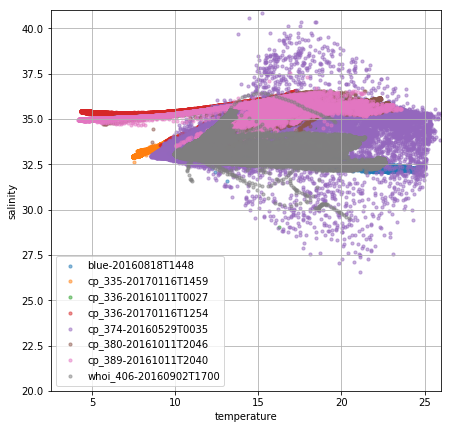

In [21]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'],
               s=10, alpha=0.5, label=glider)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)
leg = ax.legend()
ax.set_ylim(20, 41)
ax.set_xlim(2.5, 26);

# ERDDAP App example


[Timeseries Explorer](ERDDAP_timeseries_explorer-IOOS.ipynb)